# Townsend Part 1 Tutorial: BioSCape vegetation surveys, community-weighted traits, and AVIRIS-NG

Code/Conceptual Contributors: Henry Frye, Kyle Kovach, Phil Townsend 

Data contributors: John Silander

## Overview

This tutorial demonstrates how to work with the terrestrial sampling data conducted during BioSCape, link it to spectral data extracted from AVIRIS-NG imagery, and test hypotheses of how the ground data and imagery are related. In particular, the tutorial focuses on plant foliar traits and how they scale at the community level. 

## Learning objectives

1. Open, explore, and clean the BioSCape vegetation survey and cover data
2. Visualize distributions of foliar plant traits across communities dominated by different plant families
3. Calculate community weighted means of traits
4. Open and visualize extracted spectral data from AVIRIS-NG imagery
5. Create relational joins between plot-level data and extracted spectra
6. Calculate two-band vegetation indices and relate it to ground data
7. Vector normalize spectra and visualize it

## Requirements

### Load Python modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Opening and exploring the vegetation survey data

In this section you will open a subset of the BioSCape vegetation plot survey data located over the Cape peninsula. The latest version of the full dataset can be accessed on the [BioSCape terrestrial GitHub](https://github.com/BioSCape-io/BioSCape-terrestrial).

![Plot Map](../Pictures/CapePeninsulaPlotMap.png)

In [2]:
# Read in composition data for the peninsula
veg_data = pd.read_csv('../CleanData/CleanPeninsulaVegData.csv')

### Learning about the data

The code below prints the first few rows of the simplified vegetation survey data. Each plot, denoted by 'T' follow a set of three digits, contains an inventory the plant species within a fixed area. The surveying botanist provided an estimate of the percent cover value that each plant species occupies within this area. This data has a taxonomy associated with each species up to the family-level. Given how species-rich the Cape Floristic Region is, it can be difficult to make quick ecological interpration since each plot has a completely new turnover of species. It is often easier to make intepretations on the basis of plant families.


Note that these cover values can sum to values over 100 percent. This is because is plants can overlap vertically creating higher coverage values. Further, the cover values do not usually sum to 100 either. This is because there is other surfaces present within a plot such as bare soil and bare rock.

In [3]:
# Print first few rows of data
print(veg_data.head())

   Plot            GenusSpecies       Genus        Family  PercentCoverAlive
0  T068          Elegia filacea      Elegia  Restionaceae              42.50
1  T068     Berzelia lanuginosa    Berzelia    Bruniaceae              19.75
2  T068     Erica subdivaricata       Erica     Ericaceae               9.50
3  T069   Cliffortia ruscifolia  Cliffortia      Rosaceae              23.00
4  T069  Restio gaudichaudianus      Restio  Restionaceae              20.00


### How many plots are included in this data?

In [4]:
# How many plots are there within the data?
print(len(veg_data['Plot'].unique()))

24


### Let\'s next print the full list of species from the data. 



In [5]:
# Print list of all species
print(veg_data['GenusSpecies'].unique())

['Elegia filacea' 'Berzelia lanuginosa' 'Erica subdivaricata'
 'Cliffortia ruscifolia' 'Restio gaudichaudianus' 'Adenandra villosa'
 'Passerina corymbosa' 'Erica baccans' 'Tetraria ustulata'
 'Lobostemon glaucophyllus' 'Erica hispidula' 'Erica ericoides'
 'Restio cincinnatus' 'Elegia juncea' 'Tetraria compar'
 'Watsonia borbonica' 'Willdenowia glomerata' 'Leucadendron salignum'
 'Leucospermum conocarpodendron' 'Penaea mucronata'
 'Leucadendron xanthoconus' 'Restio triticeus' 'Elytropappus scaber'
 'Metalasia densa' 'Cliffortia falcata' 'Restio capensis' 'Olea capensis'
 'Pseudopentameris macrantha' 'Corymbium africanum' 'Elegia mucronata'
 'Anthochortus crinalis' 'Metalasia muricata' 'Leucadendron coniferum'
 'Passerina paleacea' 'Helichrysum patulum' 'Carpobrotus acinaciformis'
 'Protea repens' 'Thamnochortus lucens' 'Thamnochortus fraternus'
 'Erica coarctata' 'Euclea racemosa' 'Aspalathus carnosa'
 'Amphithalea ericifolia' 'Leucadendron laureolum' 'Erica labialis'
 'Staberoha banksi

### How many unique species were found across the surveys?

In [6]:
# How many species are there total?
print(len(veg_data['GenusSpecies'].unique()))

83


For those familiar with the flora of the peninsula, you may be thinking that the above number is quite low... and you would be correct if this was an exhaustive survey. *Plants of the Greater Cape Floristic Region: The Core Cape Flora* published in 2012 by Manning and Goldblatt lists that there are 2,250 species in the Cape Peninsula! There are a few reasons why the number of species listed in the survey plots is much lower than the proposed number in the flora:

1. The surveys were not designed to be exhaustive inventories of all the species in a large area. They were designed to sample vegetation across a wide variety of environmental conditions in a short amount of time within the Western Cape
2. The currently listed species are only those that appear at 5% or greater cover. This is because the surveys were designed with remote sensing in mind. It's hard to imagine that a small grass occupying 1% of a plot would contribute much to the spectral signal of a 5 m pixel.
3. The surveys only captured seasonally apparent species. There are many, many ephmeral species that would not be found at the time of the survey since they were not apparent and could not be observed.

Now let's visualize the distribution of the number of unique species within each plot, i.e. the plot species richness. Which plot has the highest number of species, which one has the lowest?

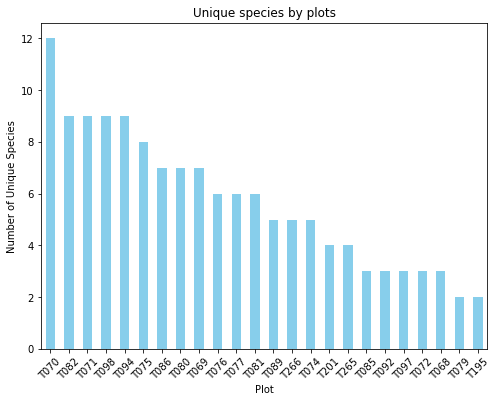

In [7]:
grouped = veg_data.groupby('Plot')['GenusSpecies'].nunique()
grouped_sorted = grouped.sort_values(ascending=False)

# Plot histogram
plt.figure(figsize=(8, 6))
grouped_sorted.plot(kind='bar', color='skyblue')
plt.title('Unique species by plots')
plt.xlabel('Plot')
plt.ylabel('Number of Unique Species')
plt.xticks(rotation=45)
plt.show()

## Interpreting the vegetation data at the family-level

Let\'s switch gears and examine the vegetation surveys after aggregating them to the family-level.

In [8]:
# Sum percent cover values by plant family within plots
fam_veg_data = veg_data.groupby(['Plot', 'Family']).agg({'PercentCoverAlive': 'sum'}).reset_index()
fam_veg_data.rename(columns={'PercentCoverAlive': 'FamilyPercentCover'}, inplace=True)

# Print first few rows of data
print(fam_veg_data.head())

   Plot        Family  FamilyPercentCover
0  T068    Bruniaceae               19.75
1  T068     Ericaceae                9.50
2  T068  Restionaceae               42.50
3  T069  Boraginaceae                5.00
4  T069    Cyperaceae                9.25


The output above shows the data now aggregated by plant family. This can be helpful in making comparisons between plots. For instance, we can say that plot T069 is dominated by a wide variety of species from different plant lineages whereas T092 is a plot largely dominated by a high cover of species in the Proteaceae family

In [9]:
print('T0069 family composition: \n', fam_veg_data[fam_veg_data['Plot'] == 'T069'])

print('\n T092 family composition: \n', fam_veg_data[fam_veg_data['Plot'] == 'T092'])

T0069 family composition: 
    Plot         Family  FamilyPercentCover
3  T069   Boraginaceae                5.00
4  T069     Cyperaceae                9.25
5  T069      Ericaceae               10.00
6  T069   Restionaceae               20.00
7  T069       Rosaceae               23.00
8  T069       Rutaceae               13.75
9  T069  Thymelaeaceae               11.75

 T092 family composition: 
     Plot      Family  FamilyPercentCover
70  T092  Bruniaceae               16.25
71  T092   Iridaceae               11.00
72  T092  Proteaceae               77.50


### How many total unique plant families are in the dataset?

In [10]:
# How many families are there total?
print(len(veg_data['Family'].unique()))

22


### Which plant families appear the most in the surveys?

In [11]:
print(fam_veg_data['Family'].value_counts().sort_values(ascending = False))

Restionaceae     18
Proteaceae       15
Ericaceae        14
Asteraceae       10
Rosaceae          5
Thymelaeaceae     5
Iridaceae         5
Cyperaceae        4
Fabaceae          3
Rutaceae          3
Bruniaceae        3
Anacardiaceae     3
Polygalaceae      3
Oleaceae          2
Poaceae           2
Aizoaceae         2
Ebenaceae         1
Penaeaceae        1
Boraginaceae      1
Rubiaceae         1
Geraniaceae       1
Rhamnaceae        1
Name: Family, dtype: int64


The above table makes a lot of sense. The first four entries, Restionaceae, Proteaceae, Ericaceae, and Asteraceae are some of the most speciose families in the Cape Floristic Region.

## Open and explore the plot cover data

Associated with the botanical inventories of the plots are estimates of the amount of bare soil, bare rock, dead vegetation and living vegetation. These are very useful ground measurements to have for remote sensing. For instance, pixels are often masked if they do not meet a certain threshhold of greenness. This kind of ground data helps validate whether this masking if effective.

In [12]:
# Step 4: Read in cover data for the peninsula
cover_data = pd.read_csv('../CleanData/CleanPeninsulaCoverData.csv')

# Print first few rows of data
print(cover_data.head())

   Plot  TotalPercentBareSurface  PercentBareSoil  PercentBareRock  \
0  T068                     4.00              3.5             0.50   
1  T069                    13.00              0.5            12.50   
2  T070                     1.00              1.0             0.00   
3  T071                    10.75              6.5             4.25   
4  T072                     0.00              0.0             0.00   

   PercentDeadVegetation  PercentLiveVegetation  
0                  13.75                  82.25  
1                  11.25                  75.75  
2                   4.25                  98.75  
3                   7.00                  82.25  
4                  47.50                  52.50  


## Visualizing relationships of cover

If we relate the percent of live vegetation cover against another cover type we may be able to understand why a plot's live vegetation is low, e.g., was there a lot of die-off creating a high amount of dead cover or perhaps there is just a lot of bare rock. Below is a graph to relate live versus dead vegetation cover. 

We may want to consider removing any outlying plots before proceeding with the analysis.

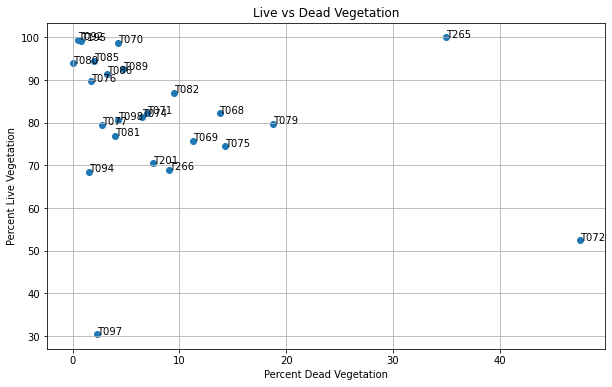

In [13]:
# Let's visualize some of the cover data by plotting the percent of live vegetation
# against percent of dead vegetation
plt.figure(figsize=(10, 6))
plt.scatter(cover_data['PercentDeadVegetation'], cover_data['PercentLiveVegetation'])

# Add labels
for i, txt in enumerate(cover_data['Plot']):
    plt.annotate(txt, (cover_data['PercentDeadVegetation'].iloc[i], cover_data['PercentLiveVegetation'].iloc[i]))

plt.xlabel('Percent Dead Vegetation')
plt.ylabel('Percent Live Vegetation')
plt.title('Live vs Dead Vegetation')
plt.grid(True)
plt.show()

In the empty code chunk below, make a different graph selecting a variable other than percent dead vegetation. T097 seems to have low live vegetation cover but also low vegetation cover. What do you think is driving this?

## Uh-oh there are a couple outlying plots

You may have noticed the T097 and T072 had very low live vegetation cover, but for different reasons. The graphs above should have helped figured out why.

Oddly, T265 has nearly 100% live cover and around 35% dead cover. The reason this happens is because of vertical structure in the vegetation. In this case there may be a dense cover of living undergrowth covering the entire plot, but some dead vegetation is overtopping that living cover. This is quite common for plots that have been burnt and have since regenerated their living growth. The picture from the plot confirms this hypothesis. We will plan on keeping this plot in the data for subsequent analysis. ![picturer](../Pictures/T265.jpeg)



### Before we proceed let's remove T097 and T072 since they have such low live vegetation cover

In [14]:
# Step 6: Remove T097 and T072 from the vegetation data. These have too low of live vegetation cover
bad_plots = ['T097', 'T072']
veg_data_update = veg_data[~veg_data['Plot'].isin(bad_plots)]

## Reading in a trait library

One of the advantages of trait ecology is that it allows ecologists to make comparisons across very different communities. While many of the plots in our data have a complete turnover in species, i.e., they do not share any of the same species in common, the species within those plots all have common chemical and structural attributes. For instance, we can ask which plots have plants with higher levels of nitrogren in their leaves. We can then form hypotheses to try to explain what causes these patterns and make inferences on how this may affect nutrient cycles within ecosystems

Below, we will read in data from a previous research project that measured plant traits across the Greater Cape Floristic Region. You will notice that each species has one averaged trait value. This is a simplifying assumption to make the analysis more straighforward even though we know that individual plants and even leaves within plants vary in their traits. The following leaf traits are shown in this data:

1. **Leaf nitrogen concentration** ($mg \cdot g^{-1}$): This trait is often seen as a proxy of photosynthtic capacity of a plant.
2. **Leaf carbon concentration** ($mg \cdot g^{-1}$): This trait is important for understanding the carbon cycle. Carbon within leaves can influence how recalcitrant leaf litter is.
3. **Leaf mass per area (LMA)** $g \cdot m^{-2}$: This trait is seen as indicative of the trade-off between leaf construction costs and the amount of light-intercepting area a leaf has. It measured by taking the dry weight of a leaf and dividing that by the leaf area. A thicker, smaller leaf has a high LMA while a large, thin leaf has low LMA.
4. **Water content** (%): This is the amount of water a leaf has, it's measured by weighing a leaf when it is freshly plucked and then drying it and reweighing it. Water plays an important role in plant growth and metabolism. 


In [15]:
# Read in the foliar trait library and make visualizations
trait_data = pd.read_csv('../CleanData/PeninsulaTraitLibrary.csv')

# Let's see the first few rows of the data
print(trait_data.head())

             GenusSpecies        Family  Mean_Nitrogen  Mean_Carbon  \
0          Elegia filacea  Restionaceae       7.949723   454.338557   
1     Berzelia lanuginosa    Bruniaceae       8.661944   524.937240   
2     Erica subdivaricata     Ericaceae       6.400000   547.000000   
3   Cliffortia ruscifolia      Rosaceae       9.146202   512.290907   
4  Restio gaudichaudianus  Restionaceae            NaN          NaN   

   Mean_Leaf_Mass_Per_Area  Mean_Water_Content  
0               390.552181           59.550936  
1               198.094137           51.309268  
2               168.949538           54.319442  
3               171.470389           47.183441  
4                      NaN                 NaN  


## Plotting the density distribution of a trait

Plotting the density distribution of plant traits is a common exploratory tool in trait ecology. A distribution with a narrow distribution may be strongly filtered by environmental conditions. Species can survive only if the fall within a narrow range of trait values. A wide distribution with large tails may suggest that the trait is not strongly selected for by the environment. A multi-modal distribution may suggest that the sampling occured over different biomes with different selection pressures.

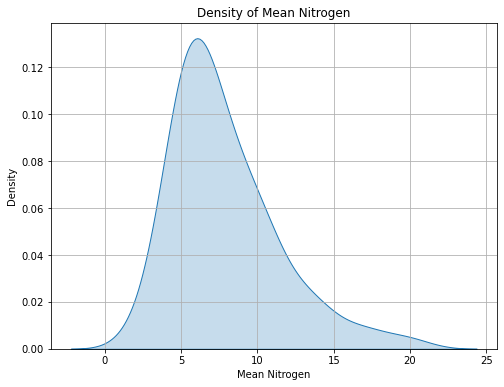

In [16]:
# Plot the density of Mean_Nitrogen
plt.figure(figsize=(8, 6))
sns.kdeplot(trait_data['Mean_Nitrogen'], shade=True)
plt.title('Density of Mean Nitrogen')
plt.xlabel('Mean Nitrogen')
plt.grid(True)
plt.show()

In the code chunk below make a density plot for a different trait

### It may be interesting to visualize the distribution of traits when separated by different plant families. 
Let's take a look at the most speciose families in our sample:

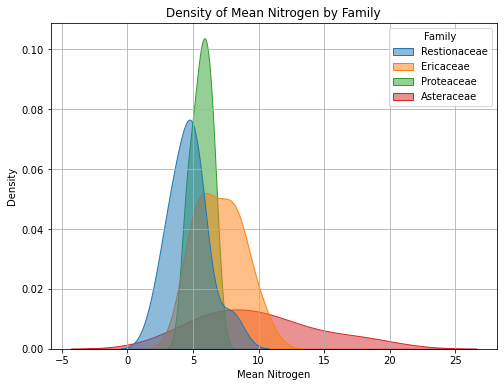

In [17]:
# Plot trait densities across prominent families
families_of_interest = ['Restionaceae', 'Ericaceae', 'Proteaceae', 'Asteraceae']
trait_data_dom_fam = trait_data[trait_data['Family'].isin(families_of_interest)]

# Density plot for families of interest
plt.figure(figsize=(8, 6))
sns.kdeplot(data=trait_data_dom_fam, x='Mean_Nitrogen', hue='Family', fill=True, alpha=0.5)
plt.title('Density of Mean Nitrogen by Family')
plt.xlabel('Mean Nitrogen')
plt.grid(True)
plt.show()

In the empty code chunk below make a new plot with either a different trait, different families, or both:

### Visualizing the relationship between traits

The relationship between traits is often used as a way to infer trade-offs between plant traits. For instance, we can correlate leaf nitrogen and leaf mass per area. Trait ecologists typically have interpreted a negative relationship between these two variables as indicating a trade-off in leaf construction vs. investment in photosynthetic capacity. Let's make a graph of this below and see if these relationships differ by plant families.

<Figure size 576x432 with 0 Axes>

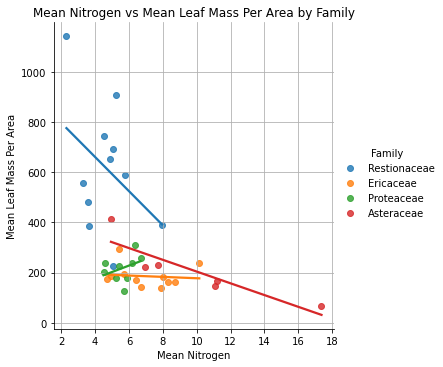

In [18]:
# Scatter plot of Mean_Nitrogen vs Mean_Leaf_Mass_Per_Area with linear fit
plt.figure(figsize=(8, 6))
sns.lmplot(data=trait_data_dom_fam, x='Mean_Nitrogen', y='Mean_Leaf_Mass_Per_Area', hue='Family', ci=None)
plt.title('Mean Nitrogen vs Mean Leaf Mass Per Area by Family')
plt.xlabel('Mean Nitrogen')
plt.ylabel('Mean Leaf Mass Per Area')
plt.grid(True)
plt.show()

## Joining the trait library to the vegetation survey data

In this section, we will join the vegetation survey data and trait libraries. Often there will be missing data since it is rare to find a complete trait library for a survey of species. We will assess the degree to which there is missing data.

In [19]:
# Join the traits library to the cleaned veg data
veg_trait = pd.merge(veg_data_update, trait_data, on=['GenusSpecies', 'Family'], how='left')

# Visualize the first few rows of the data
print(veg_trait.head())

   Plot            GenusSpecies       Genus        Family  PercentCoverAlive  \
0  T068          Elegia filacea      Elegia  Restionaceae              42.50   
1  T068     Berzelia lanuginosa    Berzelia    Bruniaceae              19.75   
2  T068     Erica subdivaricata       Erica     Ericaceae               9.50   
3  T069   Cliffortia ruscifolia  Cliffortia      Rosaceae              23.00   
4  T069  Restio gaudichaudianus      Restio  Restionaceae              20.00   

   Mean_Nitrogen  Mean_Carbon  Mean_Leaf_Mass_Per_Area  Mean_Water_Content  
0       7.949723   454.338557               390.552181           59.550936  
1       8.661944   524.937240               198.094137           51.309268  
2       6.400000   547.000000               168.949538           54.319442  
3       9.146202   512.290907               171.470389           47.183441  
4            NaN          NaN                      NaN                 NaN  


Now let's assess the proportion of data missing:

In [20]:
# Assess missing data for Mean_Nitrogen
missing_N = veg_trait['Mean_Nitrogen'].isna()

# Estimate the proportion of missing data
prop_missing = missing_N.sum() / len(veg_trait['Mean_Nitrogen'])
print(f'Proportion of missing data for Mean Nitrogen: {prop_missing:.2f}')

Proportion of missing data for Mean Nitrogen: 0.20


In the code chunk below can you check the rate of mising for another trait?

While there are ways to impute missing data for these kinds of situations, we will ignore the missing data for now and proceed with the rest of our analysis.

## Calculating community weighted means

Community-weighted means(CWM's) are a way that trait ecologist scale up from species to communities. A typical way to calculate CWMs as as follows:

$CWM = \frac{t_{1} \cdot a_{1} + t_{2} \cdot a_{2} + \ldots + t_{n} \cdot a_{n}} {a_{1} + a_{2} + \ldots + a_{n}} $ 

This formula represents the sum of all the traits of species within a community weighted by their proportional abundance. As an example lets say we have a community with three species and we know the abundance of each species based on their percent cover: Protea repens (60% cover), Elegia juncea (20% cover), and Erica hispidula (20% cover). We also know that the average amount of foliar nitrogen for each respective species within that community is $6 mg \cdot g^{-1}$, $4 mg \cdot g^{-1}$, $8 mg \cdot g^{-1}$. Using this information we would calculate the CWM as:

$CWM = \frac{6 \cdot 0.6 + 4 \cdot 0.2 +  8 \cdot 0.2} {0.6 + 0.2 + 0.2} $ 

This yields a CWM nitrogen value of $6 mg \cdot g^{-1}$. We can calculate CWMs across communities to better understand how traits are distributed across a landscape. 


The code below calculates CWMs for the vegetation data. Note that each plot now gets a single measure of a trait at that location.


In [21]:
# Calculate community weighted means (CWMs) for each trait
veg_cwm = veg_trait.groupby('Plot').apply(lambda x: pd.Series({
    'Nitrogen_CWM': (x['PercentCoverAlive'] / 100 * x['Mean_Nitrogen']).sum() / (x['PercentCoverAlive'] / 100).sum(),
    'Carbon_CWM': (x['PercentCoverAlive'] / 100 * x['Mean_Carbon']).sum() / (x['PercentCoverAlive'] / 100).sum(),
    'LMA_CWM': (x['PercentCoverAlive'] / 100 * x['Mean_Leaf_Mass_Per_Area']).sum() / (x['PercentCoverAlive'] / 100).sum(),
    'Water_CWM': (x['PercentCoverAlive'] / 100 * x['Mean_Water_Content']).sum() / (x['PercentCoverAlive'] / 100).sum()
}))

print(veg_cwm.head())
#print(veg_cwm.describe())

      Nitrogen_CWM  Carbon_CWM     LMA_CWM  Water_CWM
Plot                                                 
T068      7.940580  486.040407  308.234809  56.589652
T069      4.663506  268.561446  109.171600  29.433552
T070      5.525347  420.008646  310.010532  47.742420
T071      7.037717  390.592718  238.105077  36.900371
T074      8.553710  460.745880  287.983472  61.503757


Before we proceed, it would be helpful to also know which plant family is dominant at each plot. The code below joins this information into the community weighted mean data.

In [22]:
# Group by Plot and Family, then calculate mean cover
veg_dom = veg_trait.groupby(['Plot', 'Family'])['PercentCoverAlive'].mean().reset_index()

veg_dom = veg_dom.loc[veg_dom.groupby('Plot')['PercentCoverAlive'].idxmax()]

veg_dom = veg_dom.rename(columns={'Family': 'DominantFamily'})

veg_dom = veg_dom[['Plot', 'DominantFamily']]

veg_cwm_dom = pd.merge(veg_cwm, veg_dom, on='Plot')

## Visualizing community-weighted means

Community-weighted traits can be visualized in ways quite similar to how we visualized the trait-species library earlier, i.e., density plots and scatter plots. Below is some code that visualizes the community-weighted mean data. Feel free to change the variables of the plots.

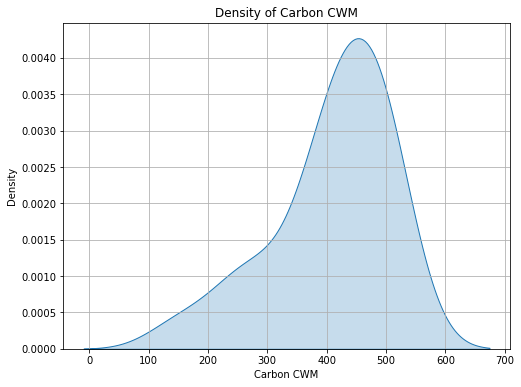

In [23]:
# Visualize the density of CWMs
plt.figure(figsize=(8, 6))
sns.kdeplot(veg_cwm['Carbon_CWM'], shade=True)
plt.title('Density of Carbon CWM')
plt.xlabel('Carbon CWM')
plt.grid(True)
plt.show()

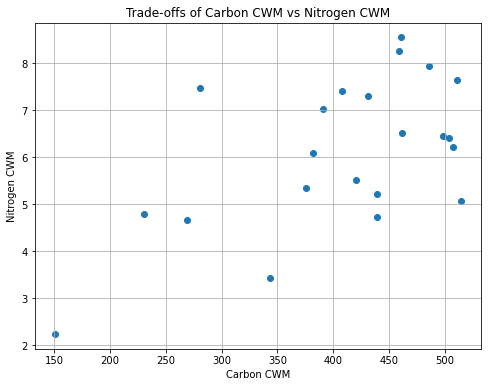

In [24]:
# Visualize trade-offs of CWMs (Carbon vs Nitrogen)
plt.figure(figsize=(8, 6))
plt.scatter(veg_cwm['Carbon_CWM'], veg_cwm['Nitrogen_CWM'])
plt.xlabel('Carbon CWM')
plt.ylabel('Nitrogen CWM')
plt.title('Trade-offs of Carbon CWM vs Nitrogen CWM')
plt.grid(True)
plt.show()

### Joining cover data and community weighted mean data
Before we proceed with the last part of our analysis using spectral data extracted from the AVIRIS-NG pixels, we will want to join together some of the plot level cover data.

In [25]:
# Join the cover data to the community weighted mean
veg_cwm_cover = pd.merge(veg_cwm_dom, cover_data, on='Plot')

# Visualize the first few rows of the data
print(veg_cwm_cover.head())

   Plot  Nitrogen_CWM  Carbon_CWM     LMA_CWM  Water_CWM DominantFamily  \
0  T068      7.940580  486.040407  308.234809  56.589652   Restionaceae   
1  T069      4.663506  268.561446  109.171600  29.433552       Rosaceae   
2  T070      5.525347  420.008646  310.010532  47.742420      Ericaceae   
3  T071      7.037717  390.592718  238.105077  36.900371     Asteraceae   
4  T074      8.553710  460.745880  287.983472  61.503757     Asteraceae   

   TotalPercentBareSurface  PercentBareSoil  PercentBareRock  \
0                    4.000              3.5            0.500   
1                   13.000              0.5           12.500   
2                    1.000              1.0            0.000   
3                   10.750              6.5            4.250   
4                   12.125             11.0            1.125   

   PercentDeadVegetation  PercentLiveVegetation  
0                  13.75                 82.250  
1                  11.25                 75.750  
2             

## Opening and visualizing extracted spectra from AVIRIS-NG tiles

Earlier in the workshop, you were shown how to extract pixels from AVIRIS-NG imagery using the plot locations over the peninsula. Below we are going to open up a csv of the reflectance spectra from those extracted pixels. Additionally, we will open a csv of the wavelength centers (in nanometers) of each band. This information is typically found in the header file of the imagery. A csv with this information already associated was created for convenience.

In [26]:
# Read in the spectra and band centers
spectra = pd.read_csv('../CleanData/ANG_RFL_CapePeninsulaVegCenters.csv')
bands = pd.read_csv('../CleanData/ANG_waves.csv')

# Create a data frame for band index
bandindex = pd.DataFrame({
    'Band': ['Band_' + str(i) for i in range(1, 426)],
    'Wavelength': bands['BandCenters']
})



## Spectral data pre-processing

Before we work with the spectral data, we have a little housekeeping to do. First, remember that we excluded a couple of the vegetation plots earlier for having low living vegetation cover values. We will want to make sure we remove those plots from the extracted data. 


In [27]:
# Subset the extracted plot to match veg data
spectra_good_plot = spectra[spectra['BScpPID'].isin(veg_cwm_cover['Plot'])]

# Check the number of unique plots match
print(len(spectra_good_plot['BScpPID'].unique()))
print(len(veg_cwm_cover['Plot'].unique()))


22
22


Second, we will want to treat bands with negative reflectance values as missing. Most of these are because water and other particles in the atmosphere cause noise in certain parts of the reflectance spectrum captured by airborne sensors. These are called atmospheric transmission windows. Most of the bands already have the "no data" value of -9999. We are going to exclude a few more noisy bands at the edges of one of these windows and treat these -9999 values as missing, i.e., assign as NaN. 

In [28]:
# Set specific bands to NA to remove atmospheric windows
bands_to_trim = ['Band_193','Band_194', 'Band_195', 'Band_196','Band_197', 'Band_208', 'Band_209', 'Band_210', 'Band_211']
spectra_trim = spectra_good_plot.copy()
spectra_trim[bands_to_trim] = -9999.000000

# Assign NA to negative reflectance values
spectra_good_plot_na = spectra_trim.copy()
spectra_good_plot_na.iloc[:, spectra_good_plot_na.columns.str.startswith('Band')] = spectra_good_plot_na.filter(like='Band').applymap(lambda x: x if x >= 0 else None)


### Joining spectral data to community weighted vegetation data

Now we are one data join away from having all the ingredients to do analysis comparing our ground sampling and airborne imagery!

In [29]:
# Join spectra with veg data
spectra_veg = pd.merge(spectra_good_plot_na, veg_cwm_cover, left_on='BScpPID', right_on='Plot')
idcol = ['BScpPID', 'Nitrogen_CWM', 'Carbon_CWM',  'Water_CWM', 'DominantFamily', 'TotalPercentBareSurface',
        'PercentBareSoil','PercentBareRock','PercentDeadVegetation', 'PercentLiveVegetation']

spectra_veg2 = spectra_veg[idcol + [col for col in spectra_veg.columns if col.startswith('Band')]]



## Visualizing spectral data 

Let's start by visualizing the mean spectral reflectance over a few of plots. These particular plots were chosen because they have dominant cover of some of the most common Fynbos families

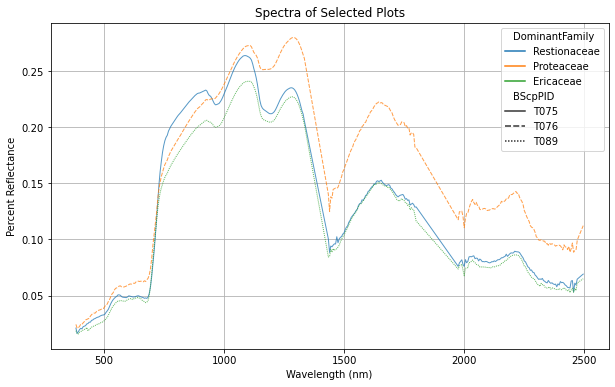

In [30]:
# Prepare data and visualize spectra

spectra_veg_vis = pd.melt(spectra_veg2, id_vars=['BScpPID', 'DominantFamily'], 
                          value_vars=[col for col in spectra_veg.columns if col.startswith('Band')],
                          var_name='Band', value_name='Reflectance')

# Average the values by band for visualization
spectra_avg = spectra_veg_vis.groupby(['BScpPID', 'DominantFamily', 'Band']).agg(MeanRefl=('Reflectance', 'mean')).reset_index()

# Join with band index to get the Wavelength column
spectra_veg_vis_ready = pd.merge(spectra_avg, bandindex, on='Band')


# Filter to plot only certain plots
spec_vis_small = spectra_veg_vis_ready[spectra_veg_vis_ready['BScpPID'].isin(['T089', 'T076', 'T075'])]

# Plot spectra
plt.figure(figsize=(10, 6))
sns.lineplot(data=spec_vis_small, x='Wavelength', y='MeanRefl', hue='DominantFamily', style='BScpPID', linewidth=1, alpha=0.75)
plt.ylabel('Percent Reflectance')
plt.xlabel('Wavelength (nm)')
plt.title('Spectra of Selected Plots')
plt.grid(True)
plt.show()

## Calculating two-band indices


Two-band indices compare the relative difference between different parts of the reflectance spectrum using this general formula:

$ \frac{Band_{x}-Band_{y}} {Band_{x} +Band_{y}} $

These types of indices are a very common tool in remote sensing. One of the most common of these indices is normalized difference vegetation index (NDVI) which calculates the relative difference between reflectance in the near-infrared reflectance versus red reflectance. One way to intepret NDVI is that it a metric of greenness. 


One hypothesis we may want to test is whether the NDVI we calculate from our extracted pixels is positively related to the overall cover estimates of living vegetation.



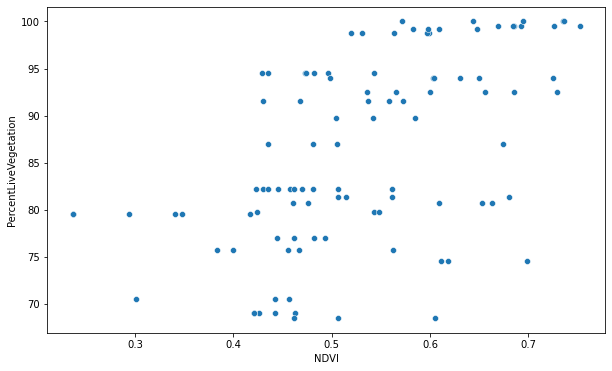

In [31]:
# Calculate NDVI 
spectra_veg_ind = spectra_veg.copy()
spectra_veg_ind['NDVI'] = (spectra_veg['Band_98'] - spectra_veg['Band_58']) / (spectra_veg['Band_98'] + spectra_veg['Band_58'])

# Plot NDVI against live percent cover
plt.figure(figsize=(10, 6))
sns.scatterplot(x='NDVI', y= 'PercentLiveVegetation', data=spectra_veg_ind)
plt.show()

Great, it looks like the general trend is positive. Higher NDVI values seem to be associated with higher amounts of living vegetation. You may note that many of the points appear in a straight line. Remember that we have multiple extracted pixels per plot while the plots only have one ground estimate of living vegetation.

Let's calculate another index, the photochemical reflectance index (PRI). PRI is based on reflectance at 531 and 570 nm and has been shown to be related to plant carotenoid pigments (particularly those of the xanthophyll cycle) and photosynthetic radiation use efficiency. In this next visualization, we will calculate PRI and compare it across different dominant families to see if this index may be useful in distinguishing vegetation dominated by different plant families.

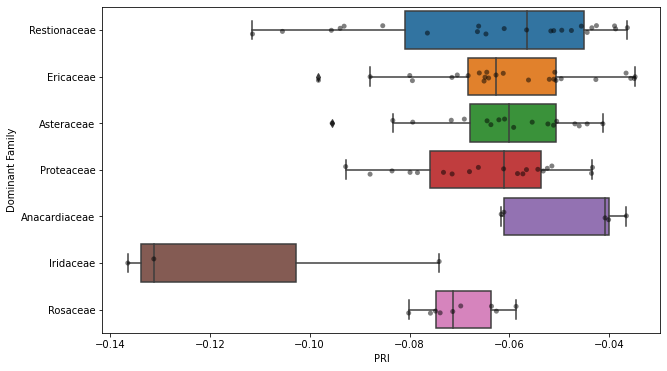

In [32]:
# Calculate PRI
spectra_veg_ind['PRI'] = (spectra_veg['Band_32'] - spectra_veg['Band_40']) / (spectra_veg['Band_32'] + spectra_veg['Band_40'])


# Plot PRI against Dominant Family
plt.figure(figsize=(10, 6))
sns.boxplot(x='PRI', y='DominantFamily', data=spectra_veg_ind)
sns.stripplot(x='PRI', y='DominantFamily', data=spectra_veg_ind, color='black', alpha=0.5)
plt.ylabel('Dominant Family')
plt.show()

Most of the families we chose to visualize have similar median PRI values. The plot dominated by the Iridaceae (Iris family) seems to have much lower PRI values. This may be because of factors unrelated to vegetation, but this is an interesting pattern that may warrant more investigation through future ground samples.  

## Generalized approach to normalized difference spectral indices

One approach to finding an index to measure a variable of interest is to test every possible two-band index and correlate all of those possiblities to the variable of interest. For instance, we may want to develop a two-band index to predict community-weighted mean carbon. 

The heatmap below is the output of this kind of analysis. We won't run this ourselves since this can be computionally intensive. The axes are the different wavelength centers and the colors are based on the $R^2$ values of the correlation of the two wavelengths in the two-band index formula and community-weighted carbon.

You might notice that the $R^2$ values are not particularly high. The indices with the highest values $R^2$ values do not explain more than 40% of the variation in carbon. This suggests that we may need other methods than two-band indices to adequately predict foliar traits. This is why methods that use more information across the spectrum, such as Partial Least Squares Regression (PLSR), are used for foliar trait prediction.  ![heatmap](../Pictures/CarbonNDSIHeatmap.png)




## Vector-normalization of spectra

The last topic to cover before we move on to the second part of the today's workshop is vector-normalization. This is a common pre-processing step done before Partial Least Squares Regression to normalize differences in canopy brightness. These brightness differences may originate from multiple different sources, but a common source is varying orientation of the foliar tissue within the canopy causing different degrees of internal shading.

To calculate normalized reflectance, each wavelength is divided by the reflectance norm. The reflectance norm is calculated as:

$\sqrt[2]{\sum_{i}^{n}R_{i}^{2}}$ 

where R is the reflectance at wavelength i.

Below is code that create a vector normalization function and then creates a plot visualizing the mean spectra for the three plots we visualized earlier. The earlier plot is also called to compare the results side-by-side.

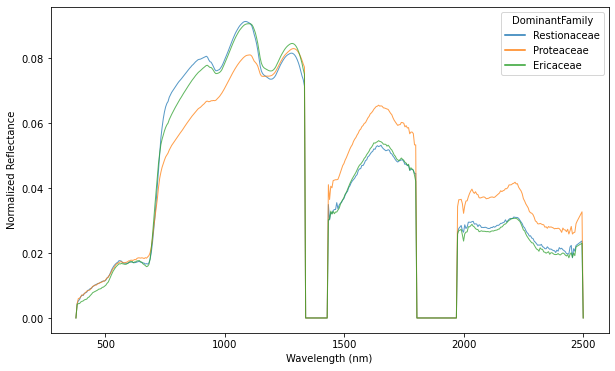

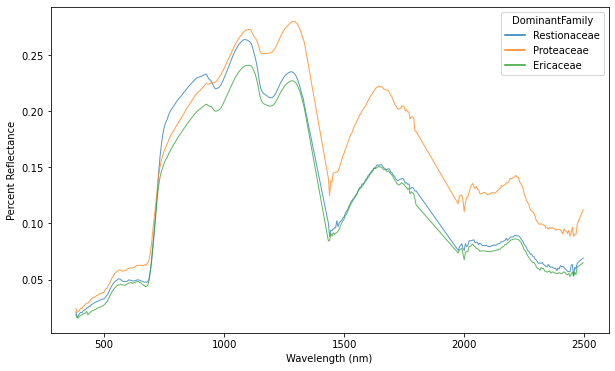

In [33]:
# Assuming spectra_veg DataFrame is already loaded

# Modified function to ensure all values are numeric and handle NaNs
def vector_norm(spectral_data):
    # Convert the data to numeric and coerce errors (non-numeric values) to NaN
    spectral_data_clean = pd.DataFrame(spectral_data).apply(pd.to_numeric, errors='coerce').values
    
    # Replace NaN values with 0 to avoid issues in the sum of squares calculation
    spectral_data_clean = np.nan_to_num(spectral_data_clean)
    
    # Calculate the norm (sum of squares) along the rows
    norm = np.sqrt(np.sum(spectral_data_clean ** 2, axis=1, keepdims=True))
    
    # Avoid division by zero (in case all values in a row are zero)
    norm[norm == 0] = 1
    
    # Normalize the spectral data
    spectravnorm = spectral_data_clean / norm
    return spectravnorm

# Example usage:
spectra = spectra_veg.filter(regex='^Band_').values  # Assuming spectra_veg has spectral bands as columns
VN_spectra = vector_norm(spectra)

# Convert the normalized array back to a pandas DataFrame (optional)
VN_spectra_df = pd.DataFrame(VN_spectra, columns=spectra_veg.filter(regex='^Band_').columns)

# Select spectral bands
spectra = spectra_veg.filter(regex='^Band_')

# Normalize spectra
VN_spectra = vector_norm(spectra.values)

# Combine normalized spectra with metadata
veg_info = spectra_veg[['BScpPID', 'DominantFamily', 'PercentLiveVegetation']]
VN_spectra_df = pd.DataFrame(VN_spectra, columns=spectra.columns)
VN_spectra_veg = pd.concat([veg_info, VN_spectra_df], axis=1)

# Reshape for visualization
VN_spectra_veg_vis = pd.melt(VN_spectra_veg, id_vars=['BScpPID', 'DominantFamily'], var_name='Band', value_name='Reflectance')

# Average the values by band
VN_spectra_avg = VN_spectra_veg_vis.groupby(['BScpPID', 'DominantFamily', 'Band']).agg({'Reflectance': 'mean'}).reset_index()

# Merge with band indices for plotting
VN_spectra_avg_ready = pd.merge(VN_spectra_avg, bandindex, on='Band', how='left')

# Plot normalized spectra for specific plots
VN_spec_vis_small = VN_spectra_avg_ready[VN_spectra_avg_ready['BScpPID'].isin(['T089', 'T076', 'T075'])]
plt.figure(figsize=(10, 6))
sns.lineplot(x='Wavelength', y='Reflectance', hue='DominantFamily', data=VN_spec_vis_small, linewidth=1, alpha=0.75)
plt.ylabel('Normalized Reflectance')
plt.xlabel('Wavelength (nm)')
plt.show()

# Compare with the original graph
spec_vis_small = spectra_veg_vis_ready[spectra_veg_vis_ready['BScpPID'].isin(['T089', 'T076', 'T075'])]
plt.figure(figsize=(10, 6))
sns.lineplot(x='Wavelength', y='MeanRefl', hue='DominantFamily', data=spec_vis_small, linewidth=1, alpha=0.75)
plt.ylabel('Percent Reflectance')
plt.xlabel('Wavelength (nm)')
plt.show()


Note that the two plots are not radically different. We are not trying to alter the spectral information content.  The Proteaceae dominated plot now has lower visible and near infrared reflectance in the normalized plots. The other two plots have closer near-infrared values in the normalized plot. 

We are now ready to move onto the next part and learn about Partial Least Squares Regression for trait prediction